<a href="https://colab.research.google.com/github/Kiran-Venkatesh/KV/blob/master/MRCNN_Xerox_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-gpu==1.15.3
!pip install tensorflow==1.15.3

     |████████████████████████████████| 110.5MB 93kB/s 
     |████████████████████████████████| 512kB 29.9MB/s 
     |████████████████████████████████| 3.8MB 48.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=30f614e5118053035ec73d1b8a539e6a56529286439a91abd0293c0612b8e597
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.3 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstall

In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 24.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 4.54 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
%cd Mask_RCNN

/content/Mask_RCNN


In [ ]:
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [ ]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


In [ ]:
!git clone https://gitlab.com/arviinnd/mrcnn_updates2.git

Cloning into 'mrcnn_updates2'...
fatal: could not read Username for 'https://gitlab.com': No such device or address


In [ ]:
import json
import cv2
 
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
  with open(filename) as f:
    data = json.load(f)
  boxes = list()
  for i in data:
    for j in data[i]['regions']:
      attrs = j['shape_attributes']
      x= attrs['all_points_x']
      y =attrs['all_points_y']
      boxes.append([x,y])
  return boxes
 
# extract details form annotation file
boxes = extract_boxes('mrcnn_updates2/annots/152.json')
# summarize extracted details
print(boxes)

[[[1229, 1241, 808, 804], [900, 1581, 1584, 900]]]


In [ ]:
# split into train and test set
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
import numpy as np
import skimage

# class that defines and loads the kangaroo dataset
class UpdateDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
  # define one class
    self.add_class("dataset", 1, "card")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 241:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 241:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.json'
      image = skimage.io.imread(img_path)
      height, width = image.shape[:2]
      self.add_image('dataset', image_id=image_id, path=img_path, width=width, height=height,annotation=ann_path)

	# extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    with open(filename) as f:
      data = json.load(f)
    boxes = list()
    for i in data:
      for j in data[i]['regions']:
        attrs = j['shape_attributes']
        x= attrs['all_points_x']
        y =attrs['all_points_y']
        boxes.append([x,y])
    return boxes

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    w = info['width']
    h = info['height']
    boxes = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype=np.uint8)
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      rr, cc = skimage.draw.polygon(box[1], box[0])
      masks[rr, cc, i] = 1
      class_ids.append(self.class_names.index('card'))
    return masks, asarray(class_ids, dtype='int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

# train set
train_set = UpdateDataset()
train_set.load_dataset('mrcnn_updates2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = UpdateDataset()
test_set.load_dataset('mrcnn_updates2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 240
Test: 60


(2339, 1653, 3)
(2339, 1653, 1)


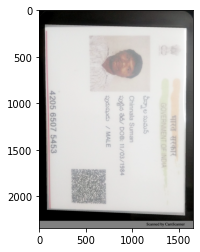

In [ ]:
# plot one photograph and mask
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot

# class that defines and loads the kangaroo dataset
class UpdateDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
  # define one class
    self.add_class("dataset", 1, "card")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 241:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 241:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.json'
      image = skimage.io.imread(img_path)
      height, width = image.shape[:2]
      self.add_image('dataset', image_id=image_id, path=img_path, width=width, height=height,annotation=ann_path)

	# extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    with open(filename) as f:
      data = json.load(f)
    boxes = list()
    for i in data:
      for j in data[i]['regions']:
        attrs = j['shape_attributes']
        x= attrs['all_points_x']
        y =attrs['all_points_y']
        boxes.append([x,y])
    return boxes

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    w = info['width']
    h = info['height']
    boxes = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype=np.uint8)
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      rr, cc = skimage.draw.polygon(box[1], box[0])
      masks[rr, cc, i] = 1
      class_ids.append(self.class_names.index('card'))
    return masks, asarray(class_ids, dtype='int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

# train set
train_set = UpdateDataset()
train_set.load_dataset('mrcnn_updates2', is_train=True)
train_set.prepare()
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

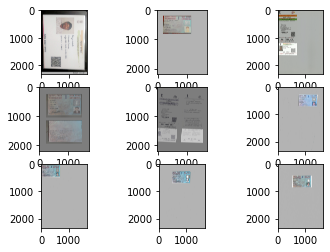

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [ ]:
# # enumerate all images in the dataset
# for image_id in train_set.image_ids:
# 	# load image info
# 	info = train_set.image_info[image_id]
# 	# display on the console
# 	print(info)

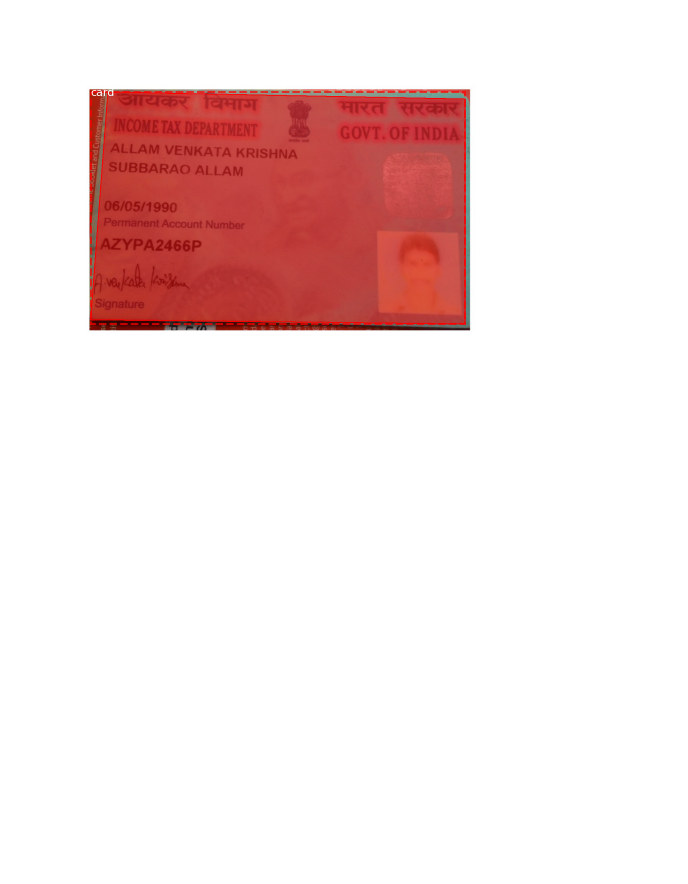

In [ ]:
# display image with masks and bounding boxes
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# class that defines and loads the kangaroo dataset
class UpdateDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
  # define one class
    self.add_class("dataset", 1, "card")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 241:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 241:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.json'
      image = skimage.io.imread(img_path)
      height, width = image.shape[:2]
      self.add_image('dataset', image_id=image_id, path=img_path, width=width, height=height,annotation=ann_path)

	# extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    with open(filename) as f:
      data = json.load(f)
    boxes = list()
    for i in data:
      for j in data[i]['regions']:
        attrs = j['shape_attributes']
        x= attrs['all_points_x']
        y =attrs['all_points_y']
        boxes.append([x,y])
    return boxes

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    w = info['width']
    h = info['height']
    boxes = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype=np.uint8)
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      rr, cc = skimage.draw.polygon(box[1], box[0])
      masks[rr, cc, i] = 1
      class_ids.append(self.class_names.index('card'))
    return masks, asarray(class_ids, dtype='int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

# train set
train_set = UpdateDataset()
train_set.load_dataset('mrcnn_updates2', is_train=True)
train_set.prepare()
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/Colab Notebooks/mask_rcnn_object_0080.h5'

In [ ]:
# fit a mask rcnn on the kangaroo dataset
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

# class that defines and loads the kangaroo dataset
class UpdateDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
  # define one class
    self.add_class("dataset", 1, "card")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 241:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 241:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.json'
      image = skimage.io.imread(img_path)
      height, width = image.shape[:2]
      self.add_image('dataset', image_id=image_id, path=img_path, width=width, height=height,annotation=ann_path)

	# extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    with open(filename) as f:
      data = json.load(f)
    boxes = list()
    for i in data:
      for j in data[i]['regions']:
        attrs = j['shape_attributes']
        x= attrs['all_points_x']
        y =attrs['all_points_y']
        boxes.append([x,y])
    return boxes

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    w = info['width']
    h = info['height']
    boxes = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype=np.uint8)
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      rr, cc = skimage.draw.polygon(box[1], box[0])
      masks[rr, cc, i] = 1
      class_ids.append(self.class_names.index('card'))
    return masks, asarray(class_ids, dtype='int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']


# define a configuration for the model
class UpdateConfig(Config):
	# define the name of the configuration
	NAME = "Update_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 240

# train set
train_set = UpdateDataset()
train_set.load_dataset('mrcnn_updates2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# test/val set
test_set = UpdateDataset()
test_set.load_dataset('mrcnn_updates2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = UpdateConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=50, layers='heads')

Using TensorFlow backend.


Train: 240
Test: 60

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/50
240/240 [==============================] - 347s 1s/step - loss: 0.4995 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1400 - val_loss: 0.3142 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.0919 - val_mrcnn_class_loss: 0.0277 - val_mrcnn_bbox_loss: 0.0831 - val_mrcnn_mask_loss: 0.1074

Epoch 2/50
240/240 [==============================] - 271s 1s/step - loss: 0.2612 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.0823 - val_loss: 0.2783 - val_rpn_class_loss: 0.0022 - val_rpn_bbox_loss: 0.1198 - val_mrcnn_class_loss: 0.0200 - val_mrcnn_bbox_loss: 0.0395 - val_mrcnn_mask_loss: 0.0968
Epoch 3/50
240/240 [==============================] - 268s 1s/step - loss: 0.1718 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0699 - val_loss: 0.2267 - val_rpn_clas

In [ ]:
%cd Mask_RCNN

[Errno 2] No such file or directory: 'Mask_RCNN'
/content/Mask_RCNN


In [ ]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


Train: 240
Test: 60


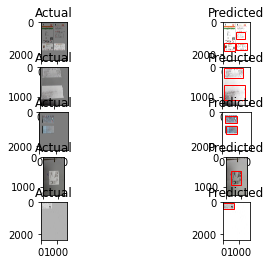

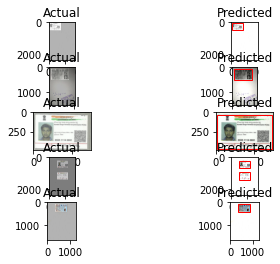

In [ ]:
# detect kangaroos in photos with mask rcnn model
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset

# class that defines and loads the kangaroo dataset
class UpdateDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir, is_train=True):
  # define one class
    self.add_class("dataset", 1, "card")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    # find all images
    for filename in listdir(images_dir):
      # extract image id
      image_id = filename[:-4]
      # skip all images after 150 if we are building the train set
      if is_train and int(image_id) >= 241:
        continue
      # skip all images before 150 if we are building the test/val set
      if not is_train and int(image_id) < 241:
        continue
      img_path = images_dir + filename
      ann_path = annotations_dir + image_id + '.json'
      image = skimage.io.imread(img_path)
      height, width = image.shape[:2]
      self.add_image('dataset', image_id=image_id, path=img_path, width=width, height=height,annotation=ann_path)

	# extract bounding boxes from an annotation file
  def extract_boxes(self, filename):
    with open(filename) as f:
      data = json.load(f)
    boxes = list()
    for i in data:
      for j in data[i]['regions']:
        attrs = j['shape_attributes']
        x= attrs['all_points_x']
        y =attrs['all_points_y']
        boxes.append([x,y])
    return boxes

  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    w = info['width']
    h = info['height']
    boxes = self.extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype=np.uint8)
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      rr, cc = skimage.draw.polygon(box[1], box[0])
      masks[rr, cc, i] = 1
      class_ids.append(self.class_names.index('card'))
    return masks, asarray(class_ids, dtype='int32')

  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "update_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i+10)
		mask, _ = dataset.load_mask(i+10)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

# load the train dataset
train_set = UpdateDataset()
train_set.load_dataset('mrcnn_updates2', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = UpdateDataset()
test_set.load_dataset('mrcnn_updates2', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = 'mask_rcnn_update_cfg_0050.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

In [ ]:
print('Train: %d' % len(train_set.image_ids))

Train: 240


In [ ]:
# TESTING CODE

In [ ]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install tensorflow==2.4.1
!pip install keras==2.4.3
!pip install segmentation-models

Uninstalling keras-nightly-2.5.0.dev2021032900:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras/*
    /usr/local/lib/python3.7/dist-packages/keras_nightly-2.5.0.dev2021032900.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/keras/applications/resnet50.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/network.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/topology.py
    /usr/local/lib/python3.7/dist-packages/keras/initializers.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/preprocessing/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/objectives.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/schedules/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/utils/test_utils.py
Proceed (y/n)?

In [ ]:
pip install --upgrade tensorflow

  Using cached https://files.pythonhosted.org/packages/aa/fd/993aa1333eb54d9f000863fe8ec61e41d12eb833dea51484c76c038718b5/tensorflow-2.5.0-cp37-cp37m-manylinux2010_x86_64.whl
     |████████████████████████████████| 1.2MB 25.1MB/s 
  Using cached https://files.pythonhosted.org/packages/d5/d1/f38a91d8724706427fe973a7dfa11e938cee98aa7196b03d870a25a08bab/grpcio-1.34.1-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/74/9eae2bedd8201ab464308f42c601a12d79727a1c87f0c867fdefb212c6cf/h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/78/b27f73e923becc6e79e18fe112cf75e3200d1ee35b0dba8fa46181bce56c/tensorflow_estimator-2.5.0-py2.py3-none-any.whl
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grp

In [ ]:
pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


In [ ]:
import tensorflow
import keras
print(tensorflow.__version__)


2.5.0


In [ ]:

from numpy import expand_dims
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

AttributeError: ignored

In [ ]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "update_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [ ]:
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = '/content/drive/MyDrive/Colab Notebooks/MRCNN Xerox/mask_rcnn_object_0080.h5'
model.load_weights(model_path, by_name=True)

AttributeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import skimage

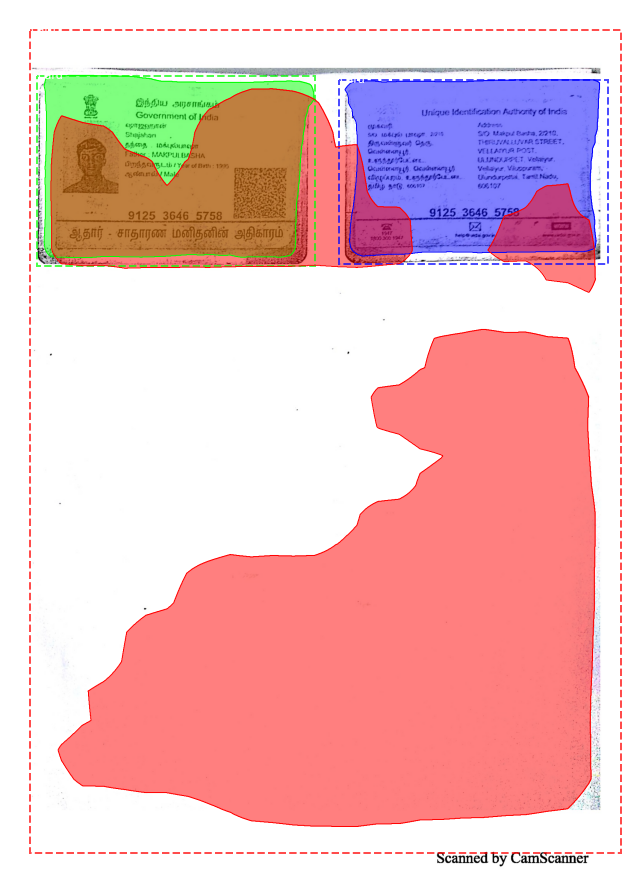

In [ ]:
image = skimage.io.imread('/content/adhar-1_1537357958_adhar.pdf.jpg')
scaled_image = mold_image(image, cfg)
# convert image into one sample
sample = expand_dims(scaled_image, 0)
# make prediction'
yhat = model.detect(sample, verbose=0)[0]
# load the masks and the class ids
class_names = ['Background','Card']
display_instances(image, yhat['rois'], yhat['masks'], yhat['class_ids'], class_names)

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 

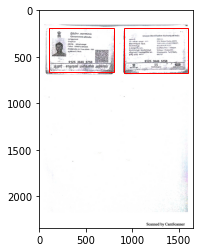

In [ ]:
img = load_img('/content/adhar-1_1537357958_adhar.pdf.jpg')
img = img_to_array(img)
# make prediction
results = model.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('/content/adhar-1_1537357958_adhar.pdf.jpg', results[0]['rois'])


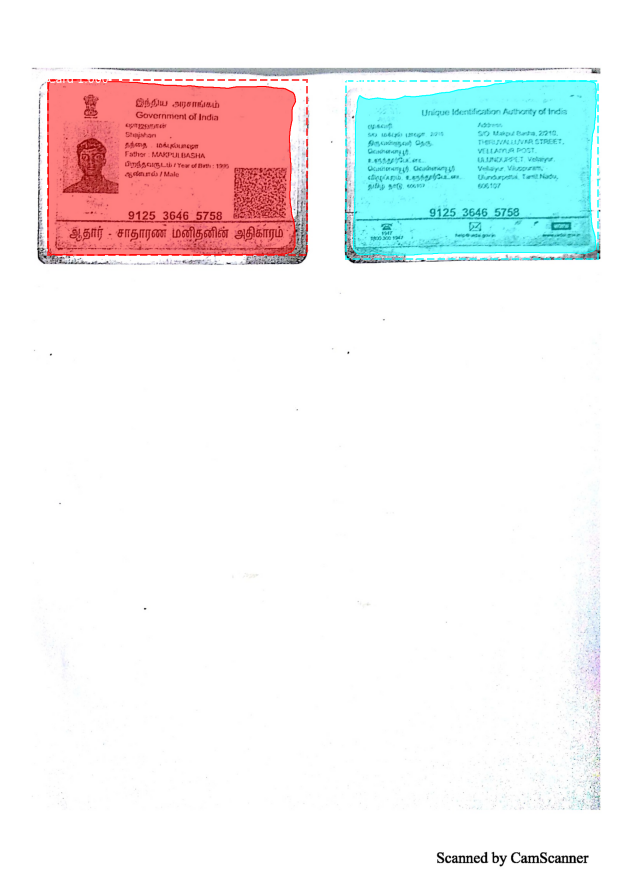

In [ ]:
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [ ]:
yhat['rois'] # 2 Cards

array([[ 176,   71,  692,  825],
       [ 188,  890,  687, 1620],
       [  52,   52, 2284, 1654]], dtype=int32)

In [ ]:
Card_1 = yhat['rois'][0] 

In [ ]:
Card_1

array([176,  71, 692, 825], dtype=int32)

In [ ]:
Card_2 = yhat['rois'][1]

In [ ]:
Card_2

array([ 188,  890,  687, 1620], dtype=int32)

In [ ]:
masks = yhat['masks']

In [ ]:
masks.shape

(2339, 1654, 3)

In [ ]:
masks[:,:,0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
def order_points(pts):
    try:
        rect = np.zeros((4, 2), dtype = "float32")            
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
    	# now, compute the difference between the points, the
    	# top-right point will have the smallest difference,
    	# whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    except:  
        print("Problem in the ordering points",traceback.print_exc())
        return("failure")

In [ ]:
def four_point_transform(image, pts):
    try:
        image=cv2.imread(image)
        rect = order_points(pts)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))       
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")    
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        return warped
    except:  
        print("Problem in the four point transform",traceback.print_exc())
        return("failure")


In [ ]:
h,w = masks[:,:,0].shape

In [ ]:
import numpy as np
import traceback
import cv2
xy = []        
for i in range(h):
    for j in range(w):
        if masks[i][j][0] == True:
            xy.append([j,i])                        
xy = np.array(xy)
aligned_rect = order_points(xy)            
warped = four_point_transform('/content/adhar-1_1537357958_adhar.pdf.jpg', aligned_rect)                    

In [ ]:
import matplotlib.pyplot as plt

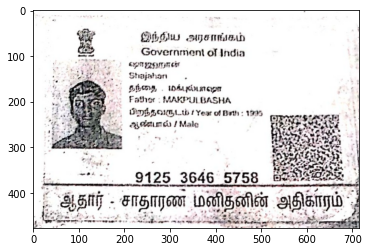

In [ ]:
plt.imshow(warped)